# MovieLens Time Series

This notebook demonstrates basic time series analysis with the MovieLens data.

## Setup

Import libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

Load the MovieLens 25M data:

In [2]:
movies = pd.read_csv('ml-25m/movies.csv').set_index('movieId')
movies.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62423 entries, 1 to 209171
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   62423 non-null  object
 1   genres  62423 non-null  object
dtypes: object(2)
memory usage: 9.6 MB


In [3]:
ratings = pd.read_csv('ml-25m/ratings.csv', dtype={
    'movieId': 'i4',
    'userId': 'i4',
    'rating': 'f4',
    'timestamp': 'i4'
})
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int32  
 1   movieId    int32  
 2   rating     float32
 3   timestamp  int32  
dtypes: float32(1), int32(3)
memory usage: 381.5 MB


MovieLens represents time with UNIX timestamps: seconds since the UNIX epoch. Convert those to a Pandas DateTime:

In [4]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

## Basic Aggregations

In order to do time-series operations, we need to *index* by time series, and sort the index:

In [5]:
rts = ratings.set_index('timestamp').sort_index()
rts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25000095 entries, 1995-01-09 11:46:49 to 2019-11-21 09:15:03
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 476.8 MB


In [6]:
monthly_ratings = rts.resample('1M')['rating'].count()
monthly_ratings

timestamp
1995-01-31         3
1995-02-28         0
1995-03-31         0
1995-04-30         0
1995-05-31         0
               ...  
2019-07-31     99159
2019-08-31    107210
2019-09-30    125523
2019-10-31     96364
2019-11-30     66464
Freq: M, Name: rating, Length: 299, dtype: int64

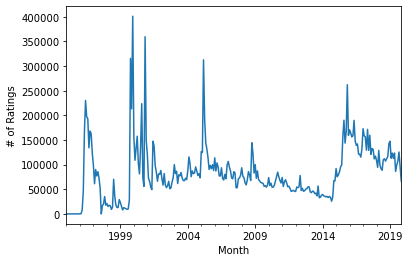

In [7]:
monthly_ratings.plot()
plt.ylabel('# of Ratings')
plt.xlabel('Month')
plt.show()

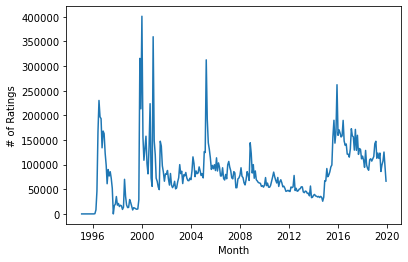

In [8]:
sns.lineplot(data=monthly_ratings)
plt.ylabel('# of Ratings')
plt.xlabel('Month')
plt.show()

## Selecting Subsets

Let's do a range select for 2010:

In [9]:
rs_2010 = rts.loc['2010-01-01':'2010-12-31']
rs_2010.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 792436 entries, 2010-01-01 00:01:13 to 2010-12-31 23:58:34
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   792436 non-null  int32  
 1   movieId  792436 non-null  int32  
 2   rating   792436 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 15.1 MB


We can also index by time interval:

In [10]:
rs_jul2010 = rts.loc['2010-07']
rs_jul2010.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66320 entries, 2010-07-01 00:23:42 to 2010-07-31 23:57:34
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   66320 non-null  int32  
 1   movieId  66320 non-null  int32  
 2   rating   66320 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 1.3 MB


## Diff and Lag

Let's compute the month-over-month growth:

In [11]:
month_growth = monthly_ratings.diff()
month_growth

timestamp
1995-01-31        NaN
1995-02-28       -3.0
1995-03-31        0.0
1995-04-30        0.0
1995-05-31        0.0
               ...   
2019-07-31    13083.0
2019-08-31     8051.0
2019-09-30    18313.0
2019-10-31   -29159.0
2019-11-30   -29900.0
Freq: M, Name: rating, Length: 299, dtype: float64

The first value is NaN, because there is no "previous" value.

Let's plot this:

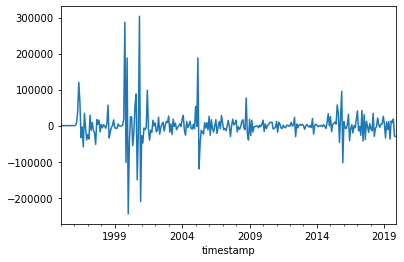

In [12]:
month_growth.plot()

## Monthly Unique Visitors

A common metric for web sites is *monthly unique visitors*.  We can't quite compute that, because we have no records of people who just came to the web site but did not rate anything.  But we can compute monthly unique active users, where a user is active if they rated a movie:

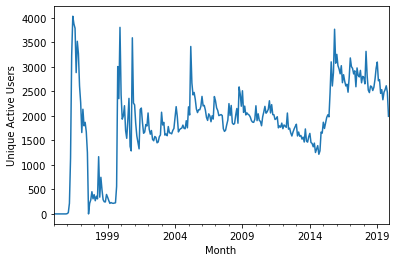

In [13]:
uniques = rts.resample('1M')['userId'].nunique()
uniques.plot()
plt.ylabel('Unique Active Users')
plt.xlabel('Month')
plt.show()

We can show the monthly growth (increase/decrease in # of unique users):

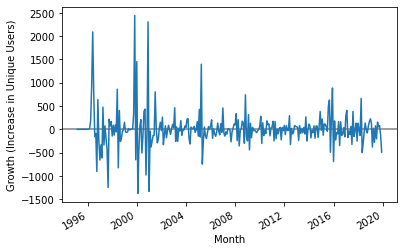

In [14]:
plt.axhline(0, color='grey')
uniques.diff().plot()
plt.ylabel('Growth (Increase in Unique Users)')
plt.xlabel('Month')
plt.show()